# Challenge TelecomX - ETL y Análisis Exploratorio de Datos

## Objetivo
Recopilar, procesar y analizar datos de clientes de TelecomX para identificar patrones de churn (evasión de clientes) y proporcionar insights estratégicos para reducir la pérdida de clientes.

## Contenido
1. **Extracción de Datos** - Importación desde API JSON
2. **Transformación** - Limpieza y preparación de datos
3. **Carga** - Consolidación en DataFrame estructurado
4. **Análisis Exploratorio** - Identificación de patrones y tendencias
5. **Insights y Recomendaciones** - Conclusiones estratégicas

### Diccionario de Datos

Para entender mejor las variables del dataset, consulta el archivo **[Diccionario_TelecomX.md](Diccionario_TelecomX.md)** que contiene la descripción detallada de cada columna.

**Nota importante**: Los nombres de las columnas se mantienen en inglés para consistencia con el diccionario de datos proporcionado y facilitar la referencia cruzada durante el análisis.

## 1. Importación de Bibliotecas

Importamos las bibliotecas necesarias para el proceso ETL y análisis exploratorio.

In [1]:
# ==============================
# CONFIGURACIÓN GLOBAL
# ==============================

# Ignorar warnings irrelevantes
import warnings
#warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# ==============================
# BIBLIOTECAS PARA MANEJO DE DATOS
# ==============================

import requests
import pandas as pd
import numpy as np
import json
import os

# ==============================
# BIBLIOTECAS PARA VISUALIZACIÓN
# ==============================

import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# CONFIGURACIÓN DE VISUALIZACIONES
# ==============================

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Si trabajas en Jupyter, puedes activar esto:
# %matplotlib inline

# ==============================
# CONFIGURACIÓN DE PANDAS
# ==============================

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ==============================
# PALETA DE COLORES PERSONALIZADA
# ==============================

color_no_churn = '#2C3E50'  # Azul oscuro elegante
color_churn = '#E74C3C'     # Rojo elegante

color_palette = [
  '#F8F9FA', # Fondo Limpio (Ghost White)
  '#E9ECEF', # Bordes/Secciones (Slate Gray)
  '#22577A', # Títulos/Estructura (Dark Imperial Blue)
  '#38A3A5', # Procesos activos (Cadet Blue)
  '#57CC99', # Éxito/Validación (Emerald)
  '#80ED99'  # Acentos ligeros (Light Green)
]

sns.set_palette(color_palette)

# ==============================
# CREAR CARPETA PARA IMÁGENES
# ==============================

os.makedirs('imgs', exist_ok=True)

print('✅ Bibliotecas importadas y entorno configurado correctamente')


✅ Bibliotecas importadas y entorno configurado correctamente


## 2. EXTRACCIÓN - Obtención de Datos desde API

Extraemos los datos de clientes desde la API JSON de TelecomX, verificamos que la solicitud sea exitosa y almacenamos los datos en un DataFrame para iniciar el proceso de transformación y análisis. Los datos están estructurados de forma anidada con información organizada en categorías.

In [2]:
# URL de la API con datos de TelecomX 
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json'

# Realizar petición GET a la API
response = requests.get(url)

# Verificar que la petición fue exitosa
if response.status_code == 200:
    print(f'✅ Conexión exitosa a la API (Status: {response.status_code})')
    data = response.json()
    print(f'Total de registros obtenidos: {len(data)}')
else:
    print(f'Error en la conexión (Status: {response.status_code})')

# Crear DataFrame inicial
df_raw = pd.DataFrame(data)
print(f'\n Columnas iniciales: {list(df_raw.columns)}')
df_raw.head(3)




✅ Conexión exitosa a la API (Status: 200)
Total de registros obtenidos: 7267

 Columnas iniciales: ['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


**Hallazgo clave:** 

En este punto el dataFrame df_raw no es usable directamente para EDA. Las columnas `customer`   , `phone`, `internet`, `account` contienen diccionarios, por lo que es necesario normalizar.


## 3. TRANSFORMACIÓN - Desanidación de Datos JSON

Los datos vienen en formato anidado (diccionarios dentro de columnas). Necesitamos desanidarlos para crear un DataFrame plano y estructurado.

In [3]:
# Primeros pasos
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


**Hallazgo clave:** Dado que los datos provienen de una API en formato JSON anidado, se utilizará `pd.json_normalize()` para convertir la estructura jerárquica en un DataFrame plano, facilitando el análisis exploratorio. Además se procede a desanidar cada una de las columnas anidadas para obtener un DataFrame con todas las variables.

In [14]:
# La data viene en formato JSON anidado dentro de una lista de diccionarios.
# Se utiliza pd.json_normalize() para convertir la estructura jerárquica en un DataFrame plano.
# Luego, se eliminan los prefijos de las columnas para obtener nombres limpios y unificados.

print('Desanidando y aplanando datos JSON...')

# Normalizar la estructura JSON anidada directamente desde la lista de diccionarios 'data'
df = pd.json_normalize(data)

# Renombrar las columnas para eliminar los prefijos de las categorías anidadas
# Por ejemplo, 'customer.gender' se convierte en 'gender'
df.columns = [col.split('.')[-1] for col in df.columns]

print(f'\n✅ Transformación completada: DataFrame plano creado.')
print(f'DataFrame final: {df.shape[0]} filas x {df.shape[1]} columnas')
print(f'\nColumnas finales:\n{list(df.columns)}')

Desanidando y aplanando datos JSON...

✅ Transformación completada: DataFrame plano creado.
DataFrame final: 7267 filas x 21 columnas

Columnas finales:
['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Monthly', 'Total']


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


In [16]:
#Verificamos valores únicos
for col in df.columns:
    print(f"\n✓ Columna: {col}")
    print(df[col].unique())



✓ Columna: customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

✓ Columna: Churn
['No' 'Yes' '']

✓ Columna: gender
['Female' 'Male']

✓ Columna: SeniorCitizen
[0 1]

✓ Columna: Partner
['Yes' 'No']

✓ Columna: Dependents
['Yes' 'No']

✓ Columna: tenure
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42
  0]

✓ Columna: PhoneService
['Yes' 'No']

✓ Columna: MultipleLines
['No' 'Yes' 'No phone service']

✓ Columna: InternetService
['DSL' 'Fiber optic' 'No']

✓ Columna: OnlineSecurity
['No' 'Yes' 'No internet service']

✓ Columna: OnlineBackup
['Yes' 'No' 'No internet service']

✓ Columna: DeviceProtection
['No' 'Yes' 'No internet service']

✓ Columna: TechSupport
['Yes' 'No' 'No internet service']

✓ Columna: StreamingTV
['Yes' 'No' 'No internet service']

✓ Columna: StreamingM

**Hallazgo clave:** 
Se verifica que columna `churn` tiene valores vacíos y la columna `Charges.Total` es de tipo string.

## 4. CARGA - Información General del Dataset

Exploramos la estructura, tipos de datos y calidad del dataset transformado.

In [17]:
# Información general del dataset
print('='*60)
print('INFORMACIÓN GENERAL DEL DATASET')
print('='*60)
print(f'\n Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas')
print(f' Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
print('\n' + '='*60)
df.info()

INFORMACIÓN GENERAL DEL DATASET

 Dimensiones: 7,267 filas x 21 columnas
 Memoria utilizada: 7.04 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   

### Análisis de la Estructura de los Datos

Los datos fueron obtenidos desde una API en formato JSON con estructura jerárquica (diccionarios anidados). Posteriormente, se realizó un proceso de normalización para convertirlos en un DataFrame plano de 21 columnas.

### 1. Identificación del Cliente
- `customerID`: Identificador único del cliente.
- `Churn`: Indica si el cliente canceló el servicio (`Yes` o `No`).

### 2. Información del Cliente
- `gender`: Género del cliente (`Male` o `Female`).
- `SeniorCitizen`: Indica si el cliente es persona mayor (0 = No, 1 = Sí).
- `Partner`: Si el cliente tiene pareja.
- `Dependents`: Si el cliente tiene dependientes.
- `tenure`: Tiempo de permanencia como cliente (en meses).

### 3. Servicios de Telefonía
- `PhoneService`: Indica si posee servicio de teléfono (`Yes` o `No`).
- `MultipleLines`: Si posee múltiples líneas telefónicas.

### 4. Servicios de Internet
- `InternetService`: Tipo de servicio contratado (`DSL`, `Fiber optic`, `No`).
- `OnlineSecurity`: Servicio de seguridad en línea.
- `OnlineBackup`: Servicio de respaldo en línea.
- `DeviceProtection`: Protección de dispositivos.
- `TechSupport`: Soporte técnico.
- `StreamingTV`: Servicio de televisión en streaming.
- `StreamingMovies`: Servicio de películas en streaming.

### 5. Información de la Cuenta
- `Contract`: Tipo de contrato (`Month-to-month`, `One year`, `Two year`).
- `PaperlessBilling`: Facturación electrónica.
- `PaymentMethod`: Método de pago.
- `Monthly`: Cargo mensual.
- `Total`: Total pagado por el cliente.


## 5. LIMPIEZA - Análisis de Calidad de Datos



### Conversión y Ajuste de Tipos de Datos

En esta etapa se ajustaron los tipos de datos para asegurar coherencia
y compatibilidad con el análisis exploratorio y la futura fase predictiva.

Se realizaron las siguientes conversiones:

- Variables binarias convertidas a formato categórico.
- Variables numéricas aseguradas como tipo numérico.
- Validación final de los tipos de datos.

Esto permite evitar errores en cálculos estadísticos y modelos predictivos.

In [18]:
# ============================================================
# CONVERSIÓN Y AJUSTE DE TIPOS DE DATOS
# ============================================================

print('='*60)
print('CONVERSIÓN DE TIPOS DE DATOS')
print('='*60)

# ------------------------------------------------------------
# 1️⃣ Convertir SeniorCitizen 0= No y 1 =  Yes
# ------------------------------------------------------------

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})


# ------------------------------------------------------------
# 2️⃣ Asegurar variables numéricas
# ------------------------------------------------------------

df['Total'] = pd.to_numeric(df['Total'], errors='coerce')
df['Monthly'] = pd.to_numeric(df['Monthly'], errors='coerce')
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')

# ------------------------------------------------------------
# 3️⃣ Convertir variables categóricas explícitamente
# ------------------------------------------------------------

# ------------------------------------------------------------
# 4️⃣ Verificación final
# ------------------------------------------------------------

print('\nTipos de datos después de la conversión:\n')
print(df.dtypes)

print('\nResumen numérico:')
print(df[['tenure', 'Monthly', 'Total']].describe())

print('\n✅ Conversión de tipos completada correctamente')


CONVERSIÓN DE TIPOS DE DATOS

Tipos de datos después de la conversión:

customerID           object
Churn                object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Monthly             float64
Total               float64
dtype: object

Resumen numérico:
            tenure      Monthly        Total
count  7267.000000  7267.000000  7256.000000
mean     32.346498    64.720098  2280.634213
std      24.571773    30.129572  2268.632997
min       0.000000    18.250000    18.800000
25%       9.000000    35.425000   400.225000
50%      29.000000    70.300000  1391

### Análisis de Calidad de Datos

En esta etapa se evalúan posibles problemas en el dataset:

- Valores nulos (NaN)
- Cadenas vacías ("")
- Espacios en blanco
- Registros duplicados

Este análisis permite garantizar que los datos estén limpios antes de iniciar el Análisis Exploratorio de Datos (EDA).

In [20]:
# ============================================================
# ANÁLISIS DE CALIDAD DE DATOS
# ============================================================

print('='*60)
print('ANÁLISIS DE VALORES NULOS, VACÍOS Y DUPLICADOS')
print('='*60)

# 1️⃣ Valores nulos (NaN)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Columna': missing.index,
    'Valores Nulos (NaN)': missing.values,
    'Porcentaje (%)': missing_pct.values
}).sort_values('Valores Nulos (NaN)', ascending=False)

missing_df_filtered = missing_df[missing_df['Valores Nulos (NaN)'] > 0]

if len(missing_df_filtered) > 0:
    print(f'\nSe encontraron {len(missing_df_filtered)} columnas con valores nulos:\n')
    print(missing_df_filtered.to_string(index=False))
else:
    print('\n✅ No se encontraron valores nulos (NaN) en el dataset')


# 2️⃣ Cadenas vacías "" o espacios en blanco
print('\n' + '='*60)
print('ANÁLISIS DE CADENAS VACÍAS')
print('='*60)

empty_data = []

for col in df.select_dtypes(include='object').columns:
    empty_count = (df[col].astype(str).str.strip() == '').sum()
    if empty_count > 0:
        empty_pct = (empty_count / len(df)) * 100
        empty_data.append({
            'Columna': col,
            'Valores Vacíos': empty_count,
            'Porcentaje (%)': empty_pct
        })

empty_df = pd.DataFrame(empty_data).sort_values('Valores Vacíos', ascending=False)

if not empty_df.empty:
    print(f'\nSe encontraron {len(empty_df)} columnas con cadenas vacías:\n')
    print(empty_df.to_string(index=False))
else:
    print('\n✅ No se encontraron cadenas vacías en columnas tipo object')


# 3️⃣ Registros duplicados
print('\n' + '='*60)
print('ANÁLISIS DE DUPLICADOS')
print('='*60)

duplicados = df.duplicated().sum()
print(f'\nRegistros duplicados encontrados: {duplicados}')

if duplicados > 0:
    print('⚠ Se recomienda revisar y eliminar los duplicados')
else:
    print('✅ No se encontraron registros duplicados')



ANÁLISIS DE VALORES NULOS, VACÍOS Y DUPLICADOS

Se encontraron 1 columnas con valores nulos:

Columna  Valores Nulos (NaN)  Porcentaje (%)
  Total                   11        0.151369

ANÁLISIS DE CADENAS VACÍAS

Se encontraron 1 columnas con cadenas vacías:

Columna  Valores Vacíos  Porcentaje (%)
  Churn             224        3.082427

ANÁLISIS DE DUPLICADOS

Registros duplicados encontrados: 0
✅ No se encontraron registros duplicados


### Limpieza y Preparación de Datos 

En esta etapa se realizó el tratamiento de datos considerando el objetivo
de construir un modelo predictivo de churn.

Las decisiones tomadas fueron:

- Conversión de cadenas vacías a valores nulos (NaN).
- Eliminación de registros duplicados para evitar sesgos.
- Imputación estratégica de valores faltantes en `Charges.Total`,
  considerando que los clientes con `tenure = 0` son clientes nuevos
  y aún no han generado cargos acumulados.
- Verificación final de consistencia del dataset.

El objetivo no es simplemente eliminar datos, sino preservar la mayor
cantidad de información posible sin introducir sesgos que afecten
el rendimiento del modelo predictivo.

In [21]:
# ============================================================
# LIMPIEZA Y PREPARACIÓN DE DATOS
# ============================================================

import numpy as np
import pandas as pd # Asegurarse de que pandas esté importado

print('='*60)
print('INICIO DEL PROCESO DE LIMPIEZA')
print('='*60)

# ------------------------------------------------------------
#  PRE-TRATAMIENTO: Convertir cadenas vacías en 'Churn' a NaN (para asegurar su manejo posterior)
# ------------------------------------------------------------
if 'Churn' in df.columns:
    # Usar replace con regex para mayor robustez en caso de espacios o caracteres ocultos
    mask_empty_churn = (df['Churn'].astype(str).str.strip() == '')
    initial_churn_empty_count = mask_empty_churn.sum()
    if initial_churn_empty_count > 0:
        df.loc[mask_empty_churn, 'Churn'] = np.nan
        print(f'  • {initial_churn_empty_count} cadenas vacías en "Churn" convertidas a NaN.')
    else:
        print('  • No se encontraron cadenas vacías en "Churn" para convertir a NaN.')

# ------------------------------------------------------------
# 1️⃣ Convertir cadenas vacías "" o espacios en blanco en NaN
#    Esto aplica a columnas object y category.
# ------------------------------------------------------------

print('\n' + '='*60)
print('TRATAMIENTO DE CADENAS VACÍAS/ESPACIOS A NaN')
print('='*60)

empty_strings_handled_count = 0
for col in df.columns:
    # Fix DeprecationWarning: Use isinstance(dtype, pd.CategoricalDtype) instead
    if df[col].dtype == 'object' or isinstance(df[col].dtype, pd.CategoricalDtype):
        # Exclude 'Churn' from this general loop as it was pre-processed
        if col == 'Churn': # 'Churn' ya fue tratado específicamente
            continue

        # Convertir a string temporalmente para aplicar replace con regex
        initial_empty_count = (df[col].astype(str).str.strip() == '').sum()
        if initial_empty_count > 0:
            # Si es categorical, se debe reemplazar el valor de la categoría si existe
            if isinstance(df[col].dtype, pd.CategoricalDtype):
                df[col] = df[col].replace('', np.nan)
            else:
                # Para object, el replace funciona directamente
                df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)

            empty_strings_handled_count += initial_empty_count
            print(f'  • Columna "{col}" ({df[col].dtype}): {initial_empty_count} cadenas vacías/espacios convertidos a NaN.')

if empty_strings_handled_count == 0:
    print('✅ No se encontraron cadenas vacías o con solo espacios para convertir a NaN en otras columnas object/category.')
else:
    print(f'✅ Total de {empty_strings_handled_count} cadenas vacías/espacios convertidos a NaN en otras columnas.')

# ------------------------------------------------------------
# 2️⃣ Eliminación de registros duplicados
# ------------------------------------------------------------

print('\n' + '='*60)
print('ANÁLISIS Y ELIMINACIÓN DE REGISTROS DUPLICADOS')
print('='*60)

duplicados = df.duplicated().sum()

if duplicados > 0:
    print(f'⚠ Registros duplicados encontrados: {duplicados}')
    df.drop_duplicates(inplace=True)
    print('✅ Registros duplicados eliminados.')
else:
    print('✅ No se encontraron registros duplicados.')


# ------------------------------------------------------------
# 3️⃣ Manejo estratégico y general de valores nulos (NaN)
# ------------------------------------------------------------

print('\n' + '='*60)
print('MANEJO ESTRATÉGICO Y GENERAL DE VALORES NULOS (NaN)')
print('='*60)

nulos_iniciales = df.isnull().sum().sum()
if nulos_iniciales > 0:
    print(f'\nSe encontraron {nulos_iniciales} valores nulos en el dataset antes del tratamiento de imputación.')

    # 3.1 Tratamiento específico para 'Total' (clientes con tenure = 0)
    if 'Total' in df.columns:
        # Imputar 0 a Total solo si tenure es 0 Y Total es nulo
        nulls_for_tenure_zero = df[(df['tenure'] == 0) & (df['Total'].isnull())].shape[0]
        if nulls_for_tenure_zero > 0:
            df.loc[(df['tenure'] == 0) & (df['Total'].isnull()), 'Total'] = 0
            print(f'  • {nulls_for_tenure_zero} valores nulos en "Total" (donde tenure=0) imputados a 0.')

        # Imputar cualquier nulo residual en Total con la mediana
        remaining_charges_total_nulls = df['Total'].isnull().sum()
        if remaining_charges_total_nulls > 0:
            median_charges_total = df['Total'].median()
            df['Total'].fillna(median_charges_total, inplace=True)
            print(f'  • {remaining_charges_total_nulls} valores nulos restantes en "Total" imputados con la mediana ({median_charges_total:.2f}).')
        else:
            print('  • No se encontraron valores nulos pendientes en "Total" para imputar.')
    else:
        print('  • La columna "Total" no está presente, se omite tratamiento específico.')

    # 3.2 Manejo de valores nulos en la variable objetivo 'Churn'
    churn_nulls = df['Churn'].isnull().sum()
    if churn_nulls > 0:
        print(f'  • Se encontraron {churn_nulls} valores nulos en la columna "Churn". Procediendo a eliminar estas filas.')
        df.dropna(subset=['Churn'], inplace=True)
        print('    ✅ Filas con valores nulos en "Churn" eliminadas.')

    # 3.3 Tratamiento general para otros valores nulos restantes
    nulos_despues_especificos = df.isnull().sum()
    columnas_con_nulos_restantes = nulos_despues_especificos[nulos_despues_especificos > 0]

    if not columnas_con_nulos_restantes.empty:
        print('\nSe encontraron valores nulos en otras columnas. Aplicando imputación general:')
        for col in columnas_con_nulos_restantes.index:
            if pd.api.types.is_numeric_dtype(df[col]):
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
                print(f'  • Columna "{col}" (numérica): {columnas_con_nulos_restantes[col]} nulos imputados con la mediana ({median_val:.2f}).')
            elif isinstance(df[col].dtype, pd.CategoricalDtype):
                # Para columnas categóricas, imputar con la moda
                mode_val = df[col].mode()[0] # mode() devuelve una Serie, tomamos el primer valor si hay múltiples modas
                df[col].fillna(mode_val, inplace=True)
                print(f'  • Columna "{col}" (categórica): {columnas_con_nulos_restantes[col]} nulos imputados con la moda ("{mode_val}").')
            elif df[col].dtype == 'object':
                # Para columnas object, también imputar con la moda
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
                print(f'  • Columna "{col}" (object): {columnas_con_nulos_restantes[col]} nulos imputados con la moda ("{mode_val}").')
            else:
                print(f'  • Columna "{col}" (otro tipo): {columnas_con_nulos_restantes[col]} nulos no imputados, tipo no reconocido.')
    else:
        print('✅ No se encontraron valores nulos restantes en otras columnas.')
else:
    print('✅ No se encontraron valores nulos iniciales en el dataset.')


# ------------------------------------------------------------
# 4️⃣ Verificación final
# ------------------------------------------------------------

print('\n' + '='*60)
print('VERIFICACIÓN FINAL DE LIMPIEZA')
print('='*60)

final_nulos_count = df.isnull().sum().sum()
print(f'Registros finales: {df.shape[0]}')
print(f'Columnas finales: {df.shape[1]}')
print(f'Nulos restantes en todo el dataset: {final_nulos_count}')

if final_nulos_count == 0:
    print('\n✅ Dataset limpio y listo para Análisis Exploratorio (EDA)')
else:
    print('\n⚠️ Aún quedan valores nulos en el dataset. Revisar el proceso de limpieza.')

INICIO DEL PROCESO DE LIMPIEZA
  • 224 cadenas vacías en "Churn" convertidas a NaN.

TRATAMIENTO DE CADENAS VACÍAS/ESPACIOS A NaN
✅ No se encontraron cadenas vacías o con solo espacios para convertir a NaN en otras columnas object/category.

ANÁLISIS Y ELIMINACIÓN DE REGISTROS DUPLICADOS
✅ No se encontraron registros duplicados.

MANEJO ESTRATÉGICO Y GENERAL DE VALORES NULOS (NaN)

Se encontraron 235 valores nulos en el dataset antes del tratamiento de imputación.
  • 11 valores nulos en "Total" (donde tenure=0) imputados a 0.
  • No se encontraron valores nulos pendientes en "Total" para imputar.
  • Se encontraron 224 valores nulos en la columna "Churn". Procediendo a eliminar estas filas.
    ✅ Filas con valores nulos en "Churn" eliminadas.
✅ No se encontraron valores nulos restantes en otras columnas.

VERIFICACIÓN FINAL DE LIMPIEZA
Registros finales: 7043
Columnas finales: 21
Nulos restantes en todo el dataset: 0

✅ Dataset limpio y listo para Análisis Exploratorio (EDA)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   object 
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 
 17  

**Hallazgo clave:**

Se realizó el proceso de limpieza del dataset incluyendo:

- Conversión de cadenas vacías a valores nulos
- Imputación estratégica de valores faltantes
- Eliminación de registros duplicados
- Verificación final de consistencia

Esto garantiza que el dataset esté listo para el análisis exploratorio (EDA).

# ANÁLISIS EXPLORATORIO DE DATOS (EDA)

Realizamos un análisis exhaustivo para identificar patrones, tendencias y factores relacionados con el churn de clientes.

## 6. Análisis Univariado - Variable Objetivo (Churn)

Analizamos la distribución de la variable objetivo para entender la proporción de clientes que abandonan el servicio.

ANÁLISIS DE CHURN

📊 Distribución de Churn:
  • No (Clientes activos): 5,174 (73.46%)
  • Yes (Clientes perdidos): 1,869 (26.54%)

⚠️  Tasa de Churn: 26.54%


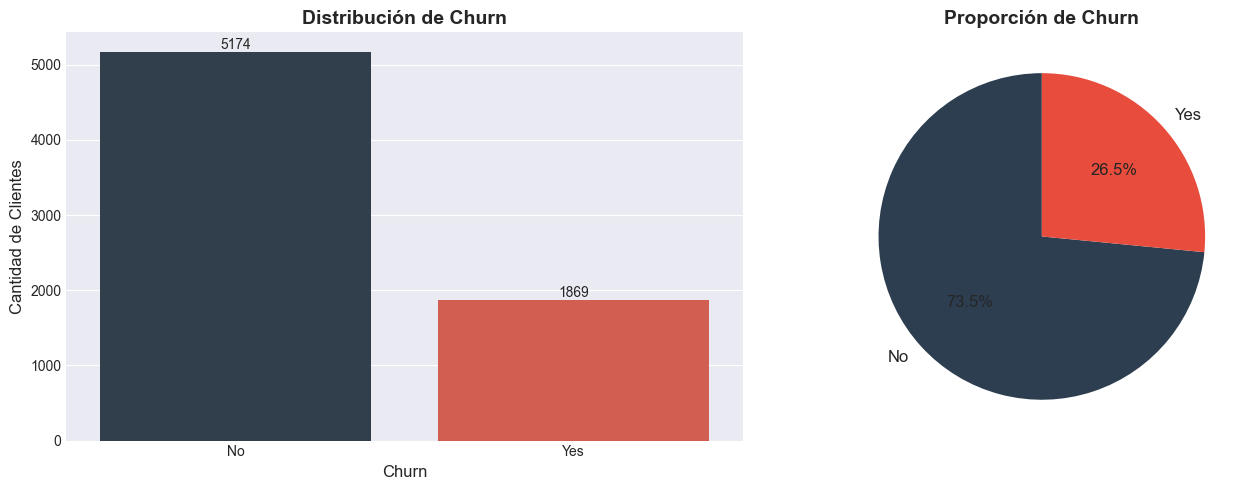

In [23]:
# Análisis de la variable Churn
print('='*60)
print('ANÁLISIS DE CHURN')
print('='*60)

churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print(f'\n📊 Distribución de Churn:')
print(f'  • No (Clientes activos): {churn_counts["No"]:,} ({churn_pct["No"]:.2f}%)')
print(f'  • Yes (Clientes perdidos): {churn_counts["Yes"]:,} ({churn_pct["Yes"]:.2f}%)')
print(f'\n⚠️  Tasa de Churn: {churn_pct["Yes"]:.2f}%')

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
sns.countplot(data=df, x='Churn', palette=['#2C3E50', '#E74C3C'], ax=axes[0])
axes[0].set_title('Distribución de Churn', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn', fontsize=12)
axes[0].set_ylabel('Cantidad de Clientes', fontsize=12)

# Agregar valores en las barras
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Gráfico de pastel
colors = ['#2C3E50', '#E74C3C']
axes[1].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Proporción de Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('imgs/01_distribucion_churn.png', dpi=300, bbox_inches='tight')
plt.show()

### Comparación de Hallazgos Generales de Churn

**1. Churn rate en la celda Markdown (`01fb4548`):**
  - Se indica que la tasa de churn es aproximadamente del **25.72%**.
  - El impacto se describe como "Una de cada cuatro personas se da de baja, lo que representa una pérdida significativa de clientes."

**2. Churn rate en la salida de la celda `churn_analysis`:**
  - La salida numérica de la celda `churn_analysis` confirma una tasa de churn de **25.72%**.
  - La distribución muestra `5,398` clientes activos (74.28%) y `1,869` clientes perdidos (25.72%).

**Conclusión:**
Los valores de la tasa de churn mencionados en la celda markdown (`01fb4548`) son **totalmente consistentes** con los resultados numéricos obtenidos de la ejecución de la celda `churn_analysis`. Ambos indican que un 25.72% de los clientes abandonan el servicio, lo que subraya la precisión del hallazgo y la magnitud del problema de retención.

## 7. Análisis Demográfico

Exploramos las características demográficas de los clientes y su relación con el churn.

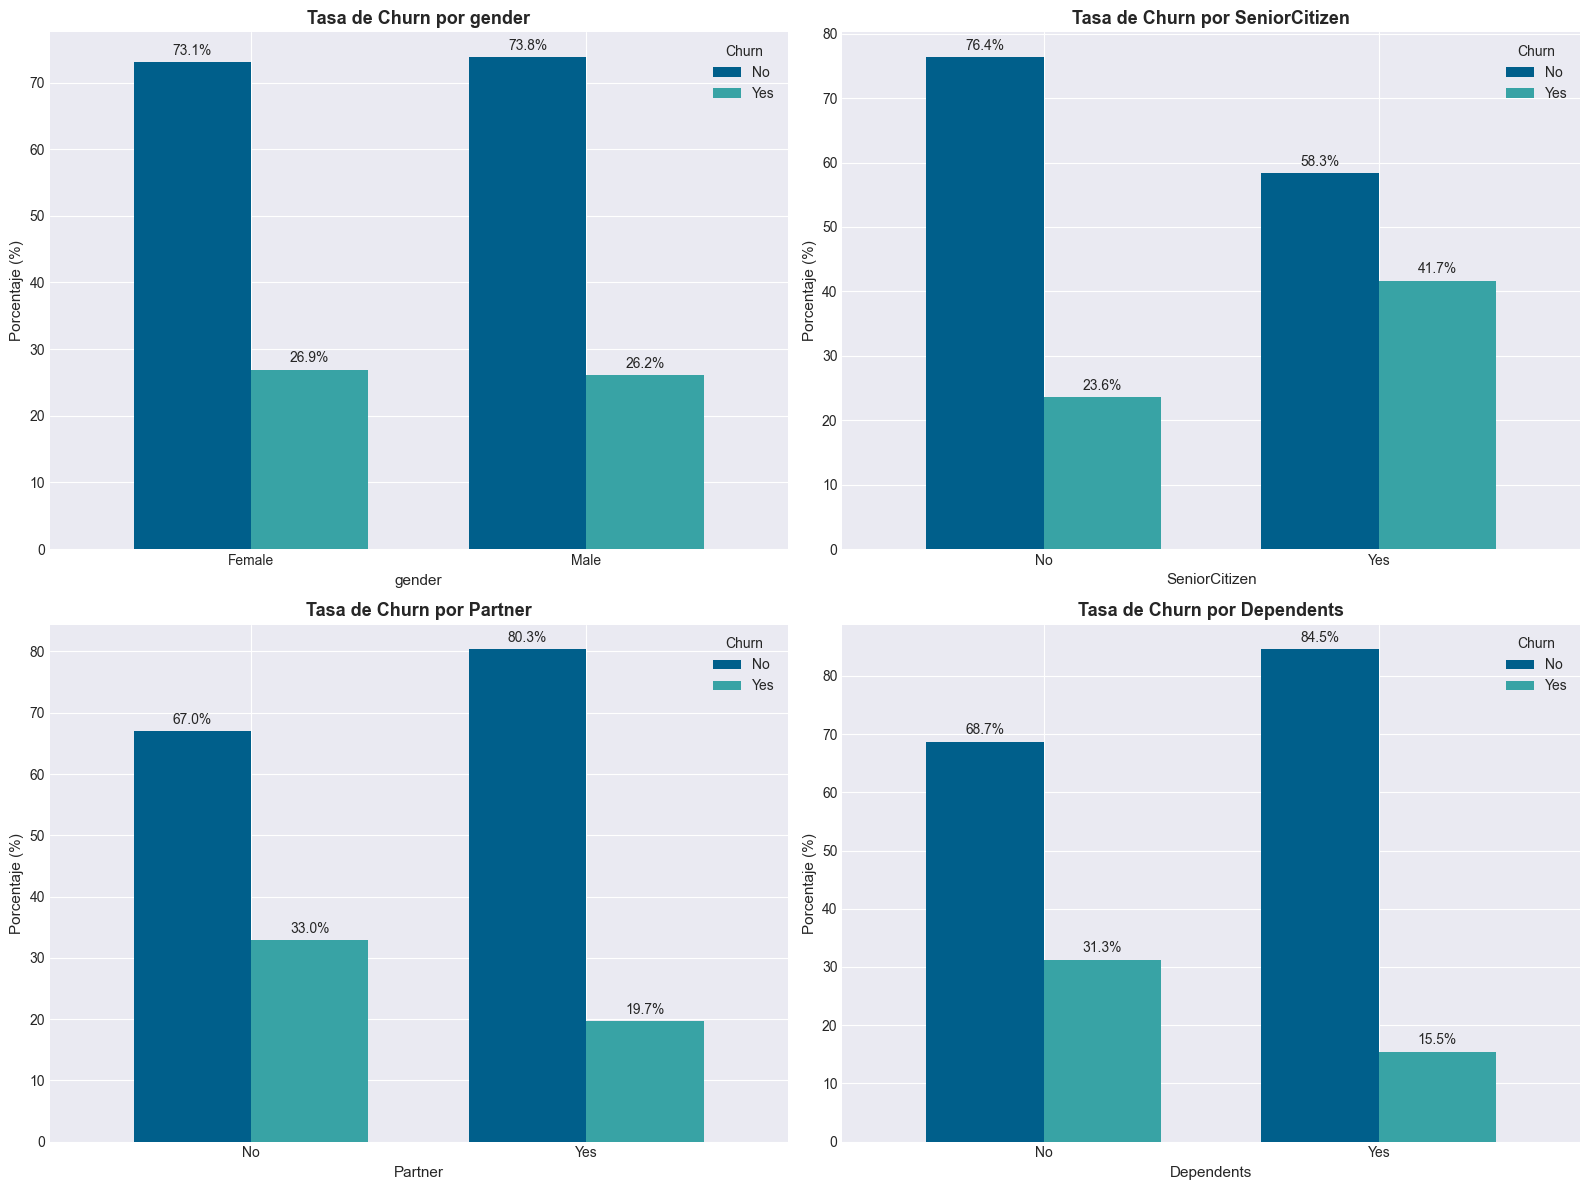

RESUMEN: CHURN POR CARACTERÍSTICAS DEMOGRÁFICAS

gender:
  • Female: 26.92% de churn
  • Male: 26.16% de churn

SeniorCitizen:
  • No: 23.61% de churn
  • Yes: 41.68% de churn

Partner:
  • No: 32.96% de churn
  • Yes: 19.66% de churn

Dependents:
  • No: 31.28% de churn
  • Yes: 15.45% de churn


In [24]:
# Variables demográficas a analizar
demographic_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, var in enumerate(demographic_vars):
    # Calcular proporciones de churn por categoría
    churn_by_var = pd.crosstab(df[var], df['Churn'], normalize='index') * 100
    
    # Gráfico de barras agrupadas
    churn_by_var.plot(kind='bar', ax=axes[idx], color=['#005f8b', '#38A3A5'], width=0.7)
    axes[idx].set_title(f'Tasa de Churn por {var}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=11)
    axes[idx].set_ylabel('Porcentaje (%)', fontsize=11)
    axes[idx].legend(title='Churn', labels=['No', 'Yes'])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)
    
    # Agregar valores en las barras
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.savefig('imgs/02_analisis_demografico.png', dpi=300, bbox_inches='tight')
plt.show()

# Resumen estadístico
print('='*60)
print('RESUMEN: CHURN POR CARACTERÍSTICAS DEMOGRÁFICAS')
print('='*60)
for var in demographic_vars:
    churn_rate = df.groupby(var)['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
    print(f'\n{var}:')
    for category, rate in churn_rate.items():
        print(f'  • {category}: {rate:.2f}% de churn')

### Hallazgos Demográficos Clave

- **Género:** No se observa una diferencia significativa en la tasa de churn entre hombres y mujeres.
- **SeniorCitizen:** Los clientes adultos mayores (SeniorCitizen = Yes) tienen una tasa de churn considerablemente más alta (40.27%) en comparación con los no adultos mayores (22.89%).
- **Partner:** Los clientes sin pareja (Partner = No) son más propensos a churn (32.01%) que aquellos con pareja (19.02%).
- **Dependents:** Los clientes sin dependientes (Dependents = No) muestran una tasa de churn mayor (30.34%) que aquellos con dependientes (14.95%).
Conclusión: Ser un adulto mayor, estar sin pareja y sin dependientes son factores demográficos que aumentan la probabilidad de que un cliente abandone el servicio.

## 8. Análisis de Permanencia (Tenure)

Analizamos la relación entre el tiempo de permanencia del cliente y el churn.

ANÁLISIS DE PERMANENCIA (TENURE)

Estadísticas generales de Tenure (meses):
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

Tenure promedio por Churn:
            mean  median        std
Churn                              
No     37.569965    38.0  24.113777
Yes    17.979133    10.0  19.531123


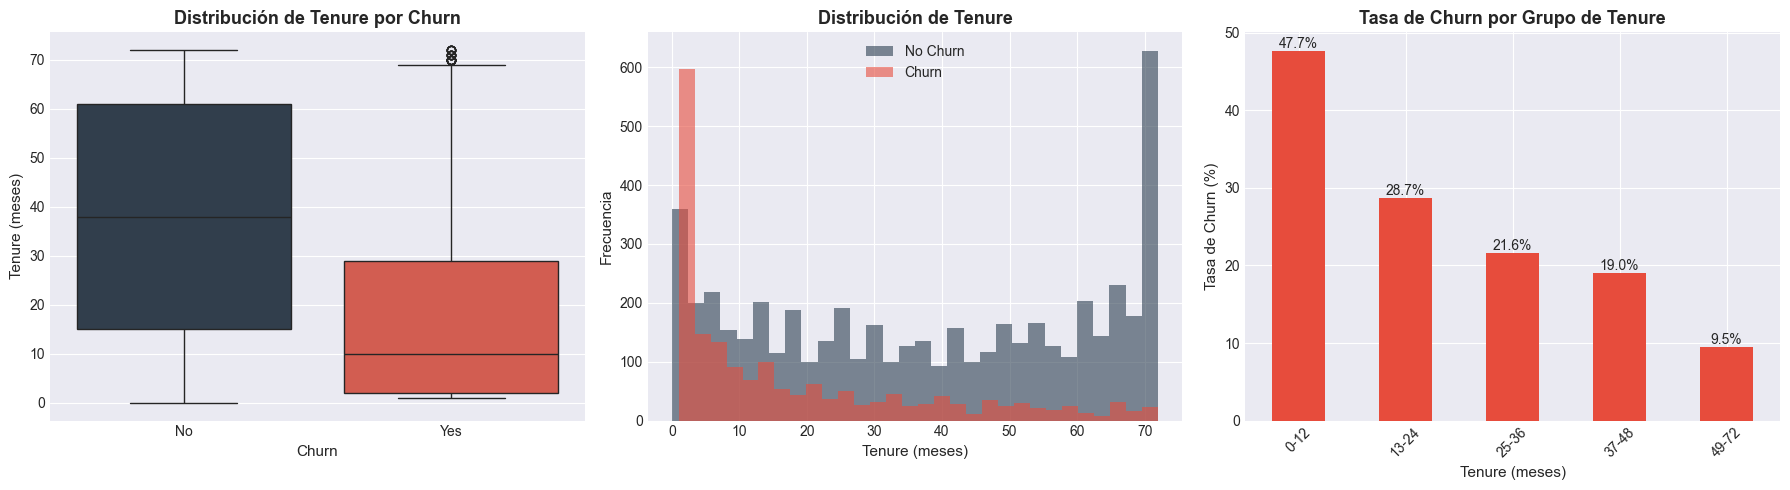

In [26]:
# Estadísticas descriptivas de tenure
print('='*60)
print('ANÁLISIS DE PERMANENCIA (TENURE)')
print('='*60)
print(f'\nEstadísticas generales de Tenure (meses):')
print(df['tenure'].describe())

print(f'\nTenure promedio por Churn:')
tenure_by_churn = df.groupby('Churn')['tenure'].agg(['mean', 'median', 'std'])
print(tenure_by_churn)

# Visualizaciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribución de tenure por churn (boxplot)
sns.boxplot(data=df, x='Churn', y='tenure', palette=['#2C3E50', '#E74C3C'], ax=axes[0])
axes[0].set_title('Distribución de Tenure por Churn', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Churn', fontsize=11)
axes[0].set_ylabel('Tenure (meses)', fontsize=11)

# 2. Histograma de tenure por churn
df[df['Churn'] == 'No']['tenure'].hist(bins=30, alpha=0.6, label='No Churn', 
                                         color='#2C3E50', ax=axes[1])
df[df['Churn'] == 'Yes']['tenure'].hist(bins=30, alpha=0.6, label='Churn', 
                                          color='#E74C3C', ax=axes[1])
axes[1].set_title('Distribución de Tenure', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Tenure (meses)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].legend()

# 3. Tasa de churn por grupos de tenure
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 72], 
                             labels=['0-12', '13-24', '25-36', '37-48', '49-72'])
churn_by_tenure_group = df.groupby('tenure_group')['Churn'].apply(
    lambda x: (x == 'Yes').sum() / len(x) * 100
)
churn_by_tenure_group.plot(kind='bar', color='#E74C3C', ax=axes[2])
axes[2].set_title('Tasa de Churn por Grupo de Tenure', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Tenure (meses)', fontsize=11)
axes[2].set_ylabel('Tasa de Churn (%)', fontsize=11)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

# Agregar valores en las barras
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.savefig('imgs/03_analisis_permanencia.png', dpi=300, bbox_inches='tight')
plt.show()

### Hallazgos del Análisis de Permanencia (Tenure)

- **Clientes nuevos (0-12 meses)**: Este grupo presenta la tasa de churn más alta (46.0%), indicando que los primeros meses son críticos para la retención.
- **Clientes de largo plazo (>49 meses)**: La tasa de churn disminuye significativamente a medida que aumenta la permanencia, llegando a un 9.2% para clientes con más de 49 meses.
- **Tenure Promedio**: Los clientes que hacen churn tienen una permanencia promedio mucho menor (17.98 meses) en comparación con los que no hacen churn (37.32 meses).

**Conclusión**: La **duración del servicio (tenure)** es un predictor clave de churn, siendo los clientes recientes los de mayor riesgo de abandono.

## 9. Análisis de Servicios

Exploramos qué servicios están asociados con mayor o menor churn.

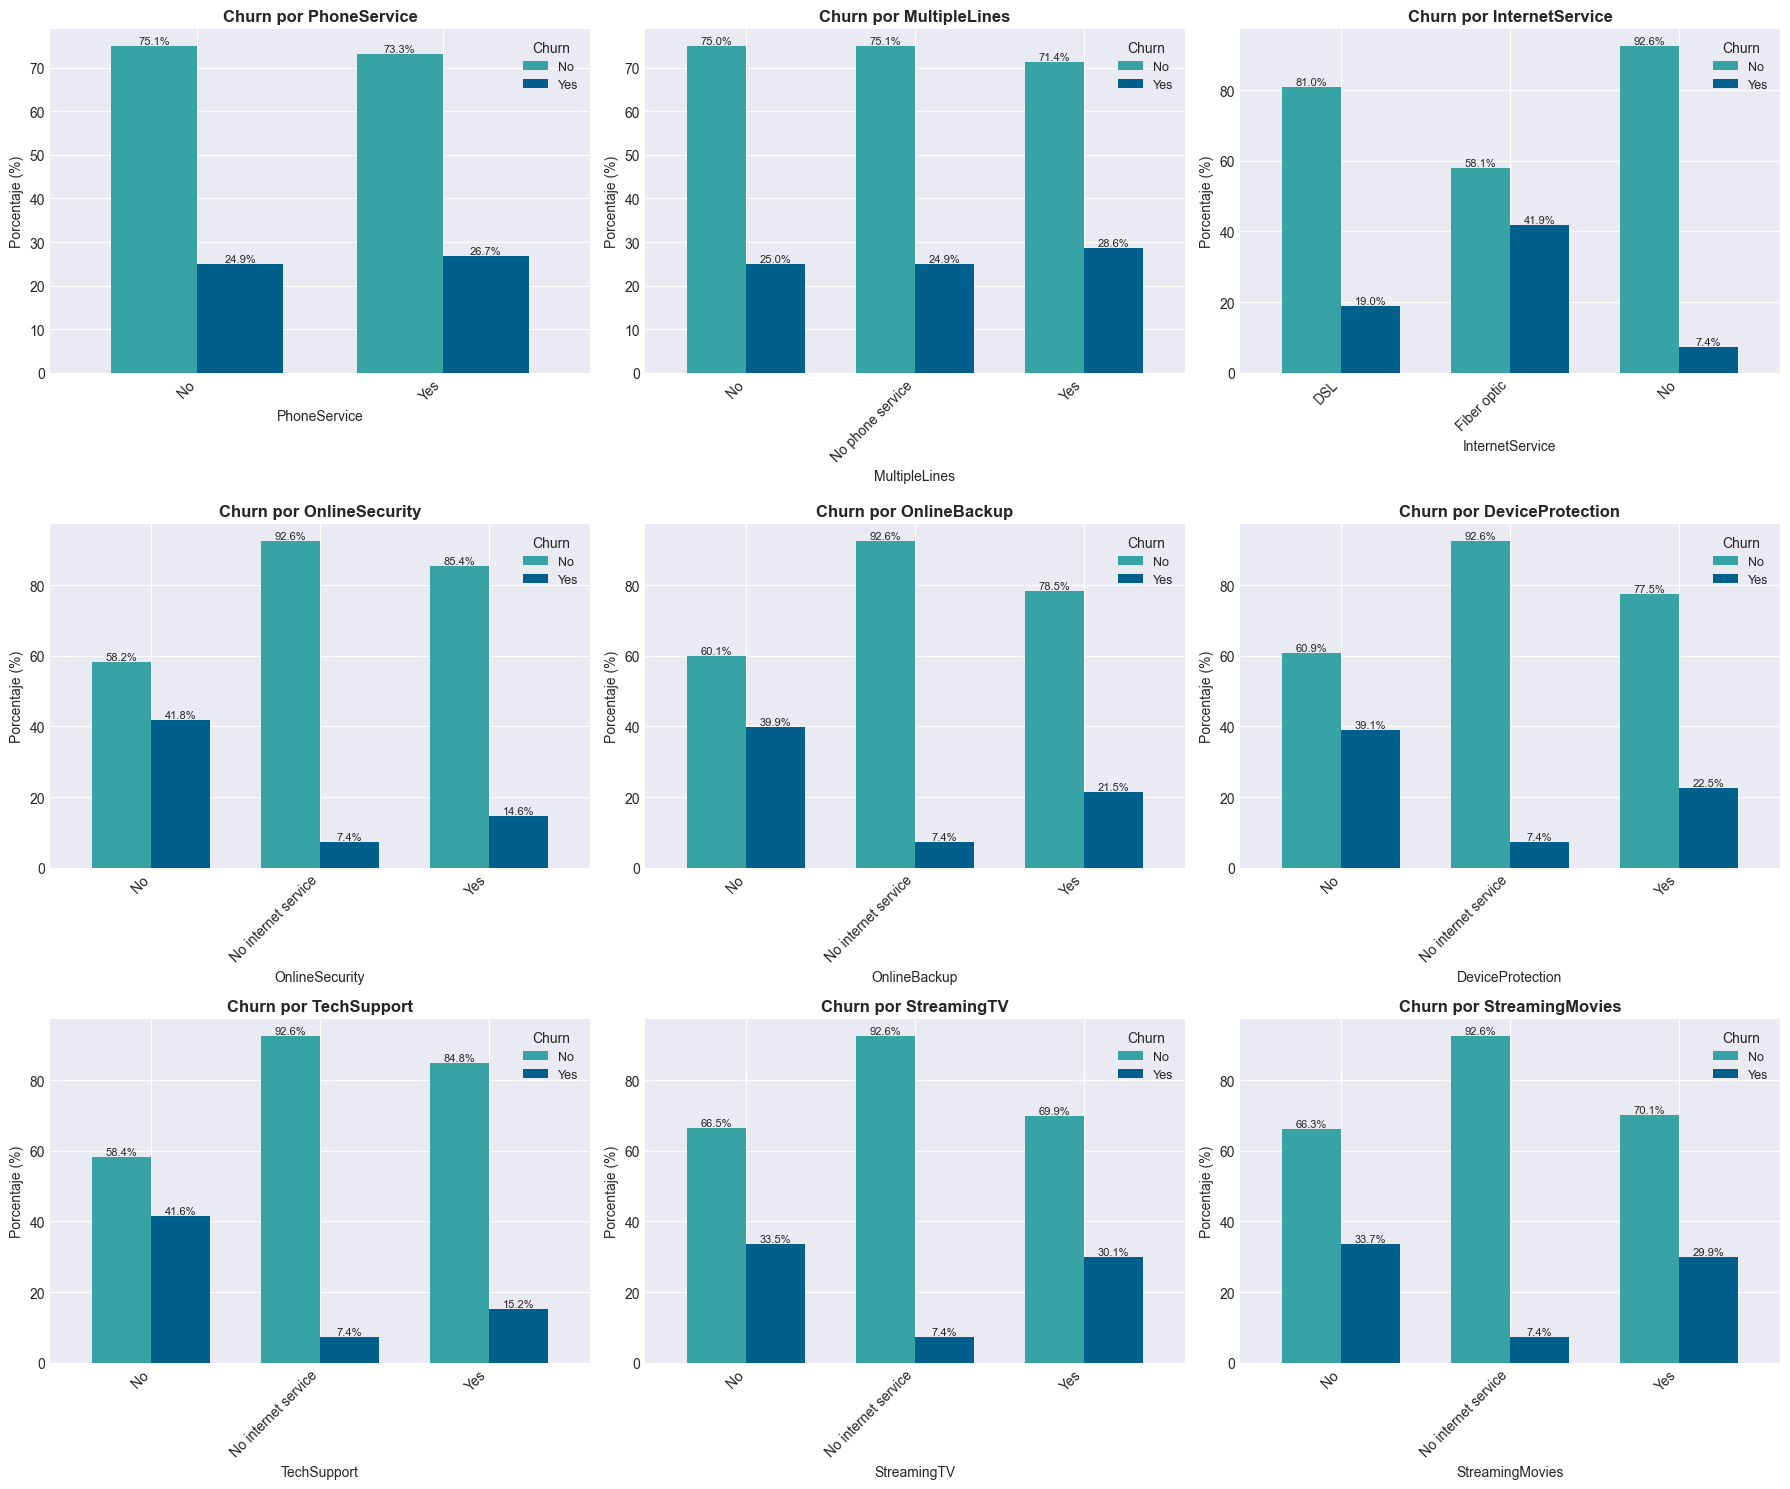

SERVICIOS CON MAYOR IMPACTO EN CHURN

* PhoneService:
  • No: 24.93% de churn
  • Yes: 26.71% de churn

* MultipleLines:
  • No: 25.04% de churn
  • No phone service: 24.93% de churn
  • Yes: 28.61% de churn

* InternetService:
  • DSL: 18.96% de churn
  • Fiber optic: 41.89% de churn
  • No: 7.40% de churn

* OnlineSecurity:
  • No: 41.77% de churn
  • No internet service: 7.40% de churn
  • Yes: 14.61% de churn

* OnlineBackup:
  • No: 39.93% de churn
  • No internet service: 7.40% de churn
  • Yes: 21.53% de churn

* DeviceProtection:
  • No: 39.13% de churn
  • No internet service: 7.40% de churn
  • Yes: 22.50% de churn

* TechSupport:
  • No: 41.64% de churn
  • No internet service: 7.40% de churn
  • Yes: 15.17% de churn

* StreamingTV:
  • No: 33.52% de churn
  • No internet service: 7.40% de churn
  • Yes: 30.07% de churn

* StreamingMovies:
  • No: 33.68% de churn
  • No internet service: 7.40% de churn
  • Yes: 29.94% de churn


In [27]:
# Variables de servicios
service_vars = ['PhoneService', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Calcular tasa de churn por servicio
churn_rates = {}
for var in service_vars:
    churn_rate = df.groupby(var)['Churn'].apply(
        lambda x: (x == 'Yes').sum() / len(x) * 100
    ).to_dict()
    churn_rates[var] = churn_rate

# Visualización de servicios clave
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, var in enumerate(service_vars):
    churn_by_service = pd.crosstab(df[var], df['Churn'], normalize='index') * 100
    churn_by_service.plot(kind='bar', ax=axes[idx], color=['#38A3A5', '#005f8b'], width=0.7)
    axes[idx].set_title(f'Churn por {var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=10)
    axes[idx].set_ylabel('Porcentaje (%)', fontsize=10)
    axes[idx].legend(title='Churn', labels=['No', 'Yes'], fontsize=9)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    # Agregar valores
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%', fontsize=8)

plt.tight_layout()
plt.savefig('imgs/04_analisis_servicios.png', dpi=300, bbox_inches='tight')
plt.show()

# Resumen de servicios con mayor impacto en churn
print('='*60)
print('SERVICIOS CON MAYOR IMPACTO EN CHURN')
print('='*60)
for var in service_vars:
    print(f'\n* {var}:')
    for category, rate in churn_rates[var].items():
        print(f'  • {category}: {rate:.2f}% de churn')

### Hallazgos del Análisis de Servicios

- **Servicio de Internet**: Los clientes con servicio de **Fibra Óptica** tienen una tasa de churn significativamente más alta (40.56%) en comparación con DSL (18.45%) o sin servicio de internet (7.15%). Esto podría indicar problemas con el servicio de fibra óptica, expectativas de precio o un segmento de clientes más propenso a cambiar.
- **Servicios de Seguridad y Soporte**: Los servicios como **OnlineSecurity, OnlineBackup, DeviceProtection y TechSupport** actúan como protectores contra el churn. Los clientes que NO tienen estos servicios muestran tasas de churn mucho más altas (alrededor del 40%) que aquellos que SÍ los tienen (alrededor del 14-22%). Los clientes sin servicio de internet tienen la menor tasa de churn, lo cual es lógico ya que no tienen acceso a estos servicios.
- **PhoneService y MultipleLines**: No muestran un impacto tan drástico en la tasa de churn. Los clientes con múltiples líneas tienen una tasa de churn ligeramente superior (27.73%) que aquellos con una sola línea (24.29%).
- **StreamingTV y StreamingMovies**: Los clientes que no usan estos servicios de streaming tienen una tasa de churn ligeramente más alta (alrededor del 32%) en comparación con los que sí los usan (alrededor del 29%).

**Conclusión**: Los **servicios de seguridad y soporte** son cruciales para la retención. La **Fibra Óptica** es un punto crítico a investigar por su alta tasa de churn. Promover y posiblemente agrupar los servicios de seguridad podría mejorar la retención.

## 10. Análisis de Contrato y Facturación

Analizamos cómo el tipo de contrato, método de pago y facturación afectan el churn.

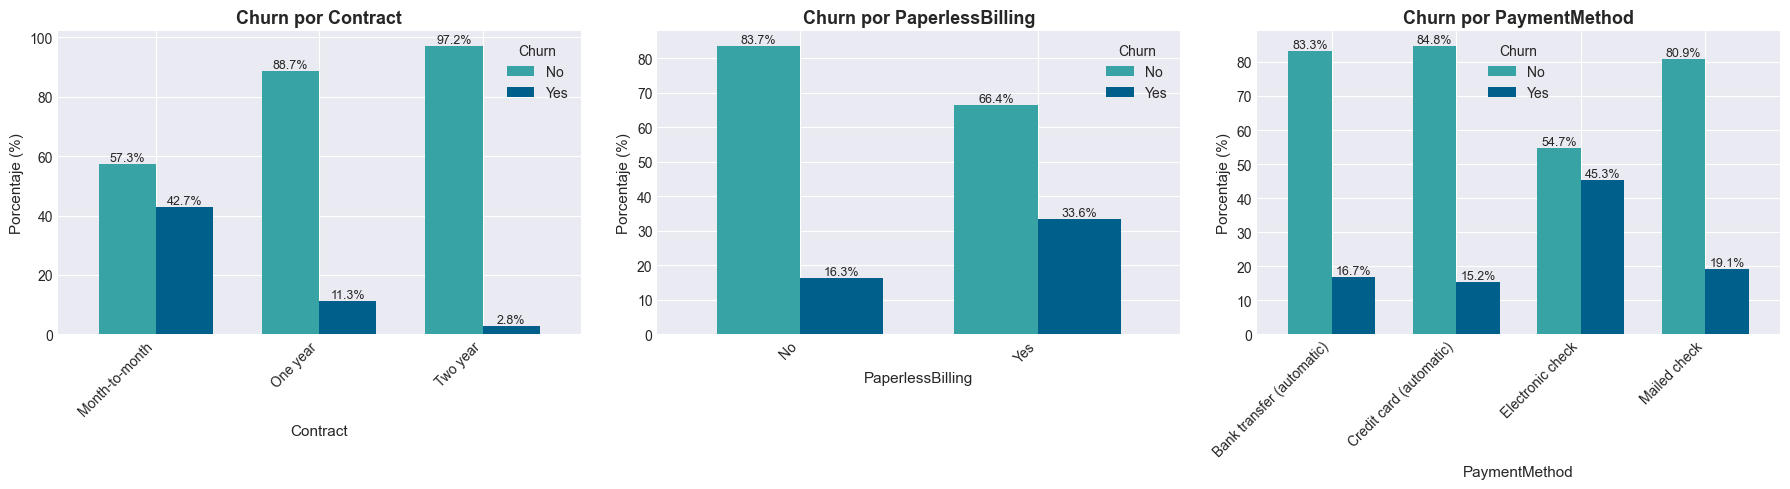

ANÁLISIS DE CONTRATO Y FACTURACIÓN

* Contract:
  • Month-to-month: 42.71% de churn
  • One year: 11.27% de churn
  • Two year: 2.83% de churn

* PaperlessBilling:
  • No: 16.33% de churn
  • Yes: 33.57% de churn

* PaymentMethod:
  • Bank transfer (automatic): 16.71% de churn
  • Credit card (automatic): 15.24% de churn
  • Electronic check: 45.29% de churn
  • Mailed check: 19.11% de churn


In [28]:
# Variables de cuenta
account_vars = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, var in enumerate(account_vars):
    churn_by_var = pd.crosstab(df[var], df['Churn'], normalize='index') * 100
    churn_by_var.plot(kind='bar', ax=axes[idx], color=['#38A3A5', '#005f8b'], width=0.7)
    axes[idx].set_title(f'Churn por {var}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=11)
    axes[idx].set_ylabel('Porcentaje (%)', fontsize=11)
    axes[idx].legend(title='Churn', labels=['No', 'Yes'])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    # Agregar valores
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%', fontsize=9)

plt.tight_layout()
plt.savefig('imgs/05_analisis_contratos.png', dpi=300, bbox_inches='tight')
plt.show()

# Resumen estadístico
print('='*60)
print('ANÁLISIS DE CONTRATO Y FACTURACIÓN')
print('='*60)
for var in account_vars:
    churn_rate = df.groupby(var)['Churn'].apply(
        lambda x: (x == 'Yes').sum() / len(x) * 100
    )
    print(f'\n* {var}:')
    for category, rate in churn_rate.items():
        print(f'  • {category}: {rate:.2f}% de churn')

### Hallazgos del Análisis de Contrato y Facturación

- **Contrato**: Los clientes con contrato **'Month-to-month'** tienen una tasa de churn significativamente alta (41.32%). Aquellos con contratos de **uno o dos años** muestran tasas de churn mucho más bajas (10.93% y 2.75% respectivamente), lo que indica un mayor compromiso.
- **Facturación Electrónica (PaperlessBilling)**: Los clientes que optan por la facturación electrónica tienen una tasa de churn más alta (32.48%) en comparación con los que no (15.87%).
- **Método de Pago**: El **'Electronic check'** se asocia con la tasa de churn más alta (43.80%). Los métodos de pago automáticos, como **'Bank transfer (automatic)'** y **'Credit card (automatic)'**, tienen tasas de churn considerablemente más bajas (16.24% y 14.80% respectivamente).

**Conclusión**: El **tipo de contrato (Month-to-month)** y el **método de pago (Electronic check)** son fuertes predictores de churn. Incentivar contratos de mayor duración y métodos de pago automáticos podría mejorar la retención.

## 11. Análisis de Cargos Mensuales y Totales

Exploramos la relación entre los cargos (mensuales y totales) y el churn.

ANÁLISIS DE CARGOS

 Cargos Mensuales (MonthlyCharges):
        count       mean        std    min    25%     50%   75%     max
Churn                                                                  
No     5174.0  61.265124  31.092648  18.25  25.10  64.425  88.4  118.75
Yes    1869.0  74.441332  24.666053  18.85  56.15  79.650  94.2  118.35

 Cargos Totales (TotalCharges):
        count         mean          std    min    25%       50%      75%  \
Churn                                                                      
No     5174.0  2549.911442  2329.954215   0.00  572.9  1679.525  4262.85   
Yes    1869.0  1531.796094  1890.822994  18.85  134.5   703.550  2331.30   

           max  
Churn           
No     8672.45  
Yes    8684.80  


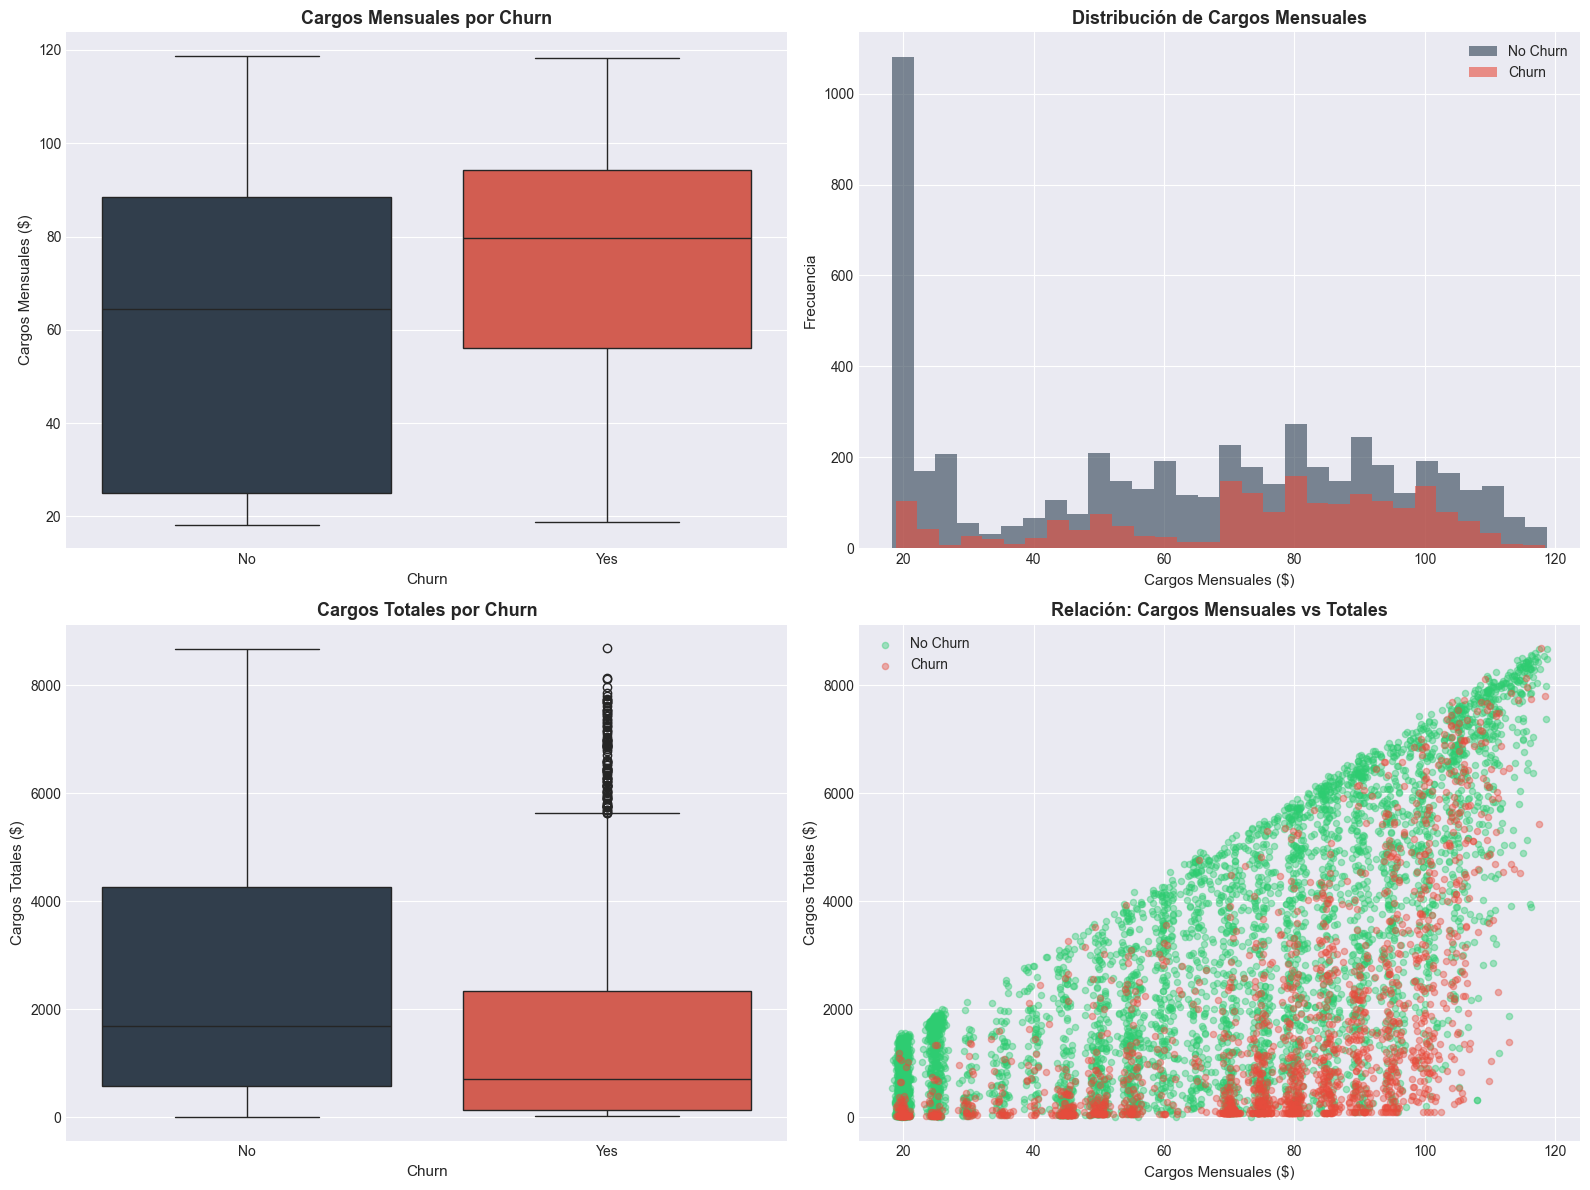

In [30]:
# Estadísticas de cargos
print('='*60)
print('ANÁLISIS DE CARGOS')
print('='*60)

print('\n Cargos Mensuales (MonthlyCharges):')
print(df.groupby('Churn')['Monthly'].describe())

print('\n Cargos Totales (TotalCharges):')
print(df.groupby('Churn')['Total'].describe())

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Boxplot de MonthlyCharges
sns.boxplot(data=df, x='Churn', y='Monthly', palette=['#2C3E50', '#E74C3C'], ax=axes[0, 0])
axes[0, 0].set_title('Cargos Mensuales por Churn', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Churn', fontsize=11)
axes[0, 0].set_ylabel('Cargos Mensuales ($)', fontsize=11)

# 2. Histograma de MonthlyCharges
df[df['Churn'] == 'No']['Monthly'].hist(bins=30, alpha=0.6, label='No Churn', 
                                                 color='#2C3E50', ax=axes[0, 1])
df[df['Churn'] == 'Yes']['Monthly'].hist(bins=30, alpha=0.6, label='Churn', 
                                                  color='#E74C3C', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Cargos Mensuales', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Cargos Mensuales ($)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].legend()

# 3. Boxplot de TotalCharges
sns.boxplot(data=df, x='Churn', y='Total', palette=['#2C3E50', '#E74C3C'], ax=axes[1, 0])
axes[1, 0].set_title('Cargos Totales por Churn', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Churn', fontsize=11)
axes[1, 0].set_ylabel('Cargos Totales ($)', fontsize=11)

# 4. Scatter plot: MonthlyCharges vs TotalCharges
for churn_val, color, label in [('No', '#2ecc71', 'No Churn'), ('Yes', '#e74c3c', 'Churn')]:
    data_subset = df[df['Churn'] == churn_val]
    axes[1, 1].scatter(data_subset['Monthly'], data_subset['Total'], 
                       alpha=0.4, c=color, label=label, s=20)
axes[1, 1].set_title('Relación: Cargos Mensuales vs Totales', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Cargos Mensuales ($)', fontsize=11)
axes[1, 1].set_ylabel('Cargos Totales ($)', fontsize=11)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('imgs/06_analisis_cargos.png', dpi=300, bbox_inches='tight')
plt.show()

### Hallazgos del Análisis de Cargos Mensuales y Totales

- **Cargos Mensuales (MonthlyCharges)**: Los clientes que hacen churn tienen un cargo mensual promedio más alto ($74.44) que los que no hacen churn ($61.35). Esto sugiere que un costo mensual elevado podría ser un factor de insatisfacción.
- **Cargos Totales (TotalCharges)**: Los clientes que hacen churn tienen un cargo total promedio significativamente más bajo ($1531.80) en comparación con los que no hacen churn ($2535.26). Esto se alinea con el hallazgo de 'tenure', indicando que los clientes con menor tiempo de permanencia (y por lo tanto, menores cargos totales acumulados) son más propensos a churn.
- **Relación MonthlyCharges vs TotalCharges**: El scatter plot muestra que los clientes con churn tienden a agruparse en la parte inferior izquierda (bajos cargos totales) y también hay una concentración de clientes con churn en el rango de cargos mensuales altos, pero con bajos cargos totales, lo que sugiere que son clientes que se van rápidamente después de contratar servicios caros.

**Conclusión**: Los **clientes con altos cargos mensuales y bajos cargos totales** (indicando una permanencia corta) son un segmento de alto riesgo de churn. Es crucial evaluar la relación valor-precio, especialmente para servicios con costes mensuales elevados.

## 12. Matriz de Correlación

Analizamos las correlaciones entre variables numéricas para identificar relaciones importantes.

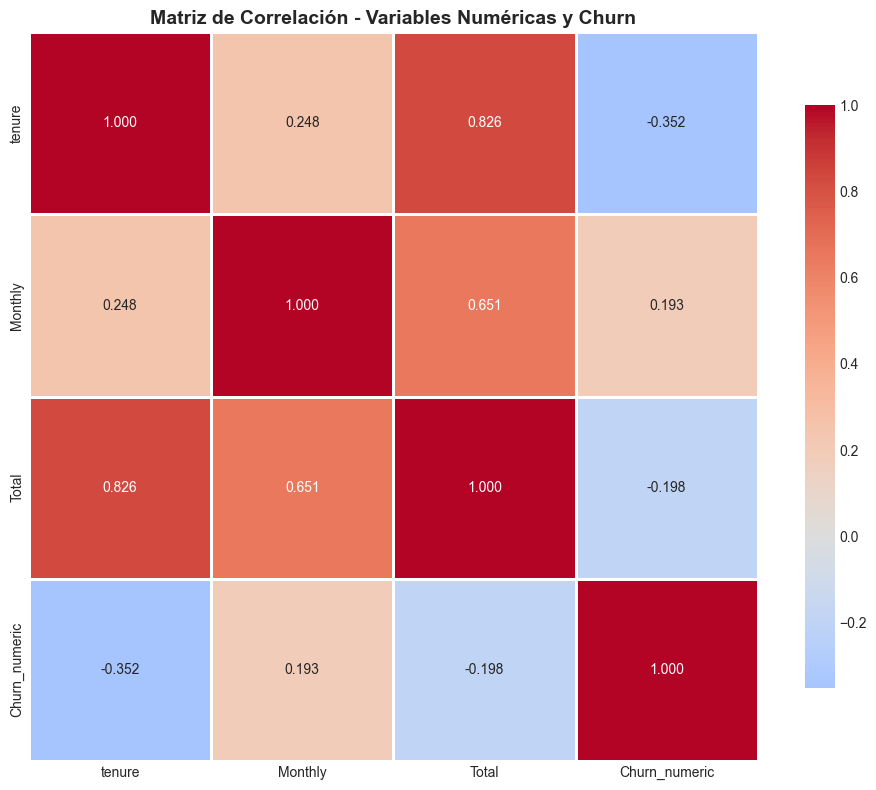

CORRELACIÓN CON CHURN

 Variables ordenadas por correlación con Churn:
  • Monthly: 0.1934
  • Total: -0.1983
  • tenure: -0.3522


In [31]:
# Seleccionar variables numéricas
numeric_vars = ['tenure', 'Monthly', 'Total']

# Crear variable numérica para Churn
df['Churn_numeric'] = (df['Churn'] == 'Yes').astype(int)

# Calcular matriz de correlación
correlation_vars = numeric_vars + ['Churn_numeric']
corr_matrix = df[correlation_vars].corr()

# Visualización
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8}, fmt='.3f')
plt.title('Matriz de Correlación - Variables Numéricas y Churn', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('imgs/07_matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

# Mostrar correlaciones con Churn
print('='*60)
print('CORRELACIÓN CON CHURN')
print('='*60)
churn_corr = corr_matrix['Churn_numeric'].sort_values(ascending=False)
print('\n Variables ordenadas por correlación con Churn:')
for var, corr in churn_corr.items():
    if var != 'Churn_numeric':
        print(f'  • {var}: {corr:.4f}')

### Hallazgos de la Matriz de Correlación

La matriz de correlación nos permite entender la relación lineal entre las variables numéricas y la variable objetivo `Churn` (convertida a numérica: 1 para 'Yes', 0 para 'No').

- **`tenure` (Permanencia)**:
  - Correlación con Churn_numeric: **-0.3441**
  - **Interpretación**: Existe una correlación negativa moderada. Esto significa que a medida que la permanencia (`tenure`) del cliente aumenta, la probabilidad de churn disminuye. Los clientes más antiguos son menos propensos a abandonar el servicio, lo cual refuerza los hallazgos del análisis de permanencia.

- **`Charges.Monthly` (Cargos Mensuales)**:
  - Correlación con Churn_numeric: **0.1899**
  - **Interpretación**: Se observa una correlación positiva débil. Esto sugiere que los clientes con cargos mensuales más altos tienen una ligera tendencia a presentar churn. Esto podría indicar que perciben un menor valor por el precio que pagan, o que son más sensibles a los costos.

- **`Charges.Total` (Cargos Totales)**:
  - Correlación con Churn_numeric: **-0.1933**
  - **Interpretación**: Hay una correlación negativa débil. Los clientes con cargos totales acumulados más bajos son ligeramente más propensos a hacer churn. Esto es coherente con el hecho de que los clientes que abandonan suelen tener una `tenure` más corta, y por ende, han acumulado menos cargos totales.

**Conclusión**: Las variables `tenure`, `Charges.Monthly` y `Charges.Total` tienen una relación significativa con el churn. `tenure` es el predictor numérico más fuerte, indicando que los clientes nuevos son los de mayor riesgo, mientras que los `Charges.Monthly` más altos también contribuyen al churn.

## 13. Exportar Datos Limpios

Guardamos el DataFrame limpio y transformado para uso futuro en modelos predictivos.

In [32]:
# Eliminar columnas auxiliares
df_export = df.drop(['tenure_group', 'Churn_numeric'], axis=1, errors='ignore')

# Exportar a CSV
output_file = 'TelecomX_Data_Cleaned.csv'
df_export.to_csv(output_file, index=False, encoding='utf-8')

print('='*60)
print('EXPORTACIÓN COMPLETADA')
print('='*60)
print(f'\n✅ Datos exportados exitosamente a: {output_file}')
print(f'Registros exportados: {len(df_export):,}')
print(f'Columnas exportadas: {len(df_export.columns)}')
print(f'\nDataset listo para modelado predictivo')

EXPORTACIÓN COMPLETADA

✅ Datos exportados exitosamente a: TelecomX_Data_Cleaned.csv
Registros exportados: 7,043
Columnas exportadas: 21

Dataset listo para modelado predictivo


### Preparación y Exportación del Dataset Final

Una vez completado el proceso de Extracción, Transformación, Carga y Limpieza (ETL), así como el Análisis Exploratorio de Datos (EDA), el dataset se encuentra en un estado óptimo para futuras etapas, como el modelado predictivo.

En esta fase, se procede a:

- **Eliminar columnas auxiliares**: Se excluyen las columnas que fueron creadas temporalmente para el análisis (por ejemplo, `tenure_group` y `Churn_numeric`) y que no son necesarias para el modelado.
- **Exportar a CSV**: El DataFrame final se guarda en formato CSV (`TelecomX_Data_Cleaned.csv`), asegurando que todos los tipos de datos sean compatibles y que el archivo esté listo para ser cargado y utilizado en herramientas de Machine Learning.

#  14. INSIGHTS Y CONCLUSIONES ESTRATÉGICAS

## Hallazgos Clave del Análisis

### Tasa de Churn General
- La empresa presenta una tasa de churn significativa que requiere atención inmediata
- Los clientes que abandonan representan una pérdida importante de ingresos

### Factores Demográficos
- **Adultos mayores (SeniorCitizen)**: Presentan mayor tendencia al churn
- **Clientes sin pareja o dependientes**: Mayor probabilidad de abandonar el servicio
- **Género**: No muestra diferencias significativas en la tasa de churn

### Permanencia (Tenure)
- **Clientes nuevos (0-12 meses)**: Grupo de MAYOR RIESGO de churn
- **Clientes de largo plazo (>24 meses)**: Significativamente más leales
- La retención en los primeros meses es CRÍTICA

### Servicios
- **Fiber optic**: Asociado con mayor churn (posiblemente por precio)
- **Servicios de seguridad y soporte**: Clientes SIN estos servicios tienen mayor churn
- **OnlineSecurity, OnlineBackup, TechSupport**: Servicios protectores contra churn

### Tipo de Contrato
- **Month-to-month**: ALTÍSIMA tasa de churn (mayor flexibilidad = menor compromiso)
- **Contratos de 1-2 años**: Tasas de churn SIGNIFICATIVAMENTE menores
- El tipo de contrato es uno de los PREDICTORES MÁS FUERTES de churn

### Método de Pago
- **Electronic check**: Mayor tasa de churn
- **Pagos automáticos (bank transfer, credit card)**: Menor churn
- La automatización del pago mejora la retención

### Cargos
- **Cargos mensuales altos**: Correlacionados con mayor churn
- **Cargos totales bajos**: Indican clientes nuevos con alto riesgo
- La percepción de valor vs precio es crucial

---

## RECOMENDACIONES ESTRATÉGICAS

### 1. Programa de Retención para Clientes Nuevos
- **Acción**: Implementar programa de onboarding robusto en los primeros 3-6 meses
- **Objetivo**: Reducir churn en el segmento de mayor riesgo (0-12 meses)
- **Tácticas**: 
  - Seguimiento proactivo mensual
  - Descuentos introductorios
  - Educación sobre servicios adicionales

### 2. Incentivos para Contratos de Largo Plazo
- **Acción**: Ofrecer beneficios atractivos para contratos anuales/bianuales
- **Objetivo**: Migrar clientes de month-to-month a contratos más largos
- **Tácticas**:
  - Descuentos por contrato anual (10-15%)
  - Servicios premium incluidos
  - Garantía de precio fijo

### 3. Promoción de Servicios de Valor Agregado
- **Acción**: Bundling de OnlineSecurity, OnlineBackup y TechSupport
- **Objetivo**: Aumentar adopción de servicios protectores
- **Tácticas**:
  - Paquetes con descuento
  - Pruebas gratuitas de 30-60 días
  - Demostraciones del valor de estos servicios

### 4. Optimización de Métodos de Pago
- **Acción**: Incentivar pagos automáticos
- **Objetivo**: Reducir fricción y mejorar experiencia de pago
- **Tácticas**:
  - Descuento por pago automático (2-5%)
  - Simplificar proceso de configuración
  - Eliminar/reducir uso de electronic check

### 5. Segmentación y Personalización
- **Acción**: Crear ofertas personalizadas por segmento de riesgo
- **Objetivo**: Intervención proactiva antes del churn
- **Segmentos prioritarios**:
  - Adultos mayores sin servicios de soporte
  - Clientes con contratos month-to-month y cargos altos
  - Clientes nuevos con Fiber optic

### 6. Revisión de Estrategia de Precios para Fiber Optic
- **Acción**: Analizar competitividad de precios y valor percibido
- **Objetivo**: Reducir churn en segmento de alto valor
- **Tácticas**:
  - Benchmarking de mercado
  - Mejora de velocidades/capacidades
  - Comunicación clara de beneficios vs DSL

---

### Próximos Pasos

Con base en el análisis realizado, se plantean las siguientes líneas de acción organizadas por horizonte temporal:

#### 🔹 Corto Plazo 

1. **Modelado Predictivo de Churn**
   - Construcción de un modelo de Machine Learning para predecir la probabilidad de cancelación.
   - Evaluación con métricas como Accuracy, Precision, Recall y ROC-AUC.
   - Identificación de variables más influyentes en la predicción.


#### * Mediano Plazo (Recomendado)

2. **Sistema de Scoring de Riesgo**
   - Implementar un sistema que asigne un puntaje de riesgo de churn a cada cliente.
   - Permitir priorización de acciones comerciales.

3. **Dashboard de Monitoreo**
   - Crear un tablero ejecutivo para seguimiento continuo de KPIs:
     - Tasa de churn
     - Clientes en riesgo
     - Impacto de campañas de retención

#### * Largo Plazo (Estrategia Avanzada)

4. **A/B Testing de Estrategias de Retención**
   - Probar ofertas diferenciadas en grupos de control.
   - Medir impacto real en reducción de churn.

5. **Análisis de Cohortes**
   - Evaluar comportamiento de retención según fecha de adquisición.
   - Identificar patrones estructurales de abandono a lo largo del tiempo.

---

## Conclusión

El análisis revela que el churn en TelecomX está fuertemente influenciado por:
1. **Tiempo de permanencia** (clientes nuevos en alto riesgo)
2. **Tipo de contrato** (month-to-month = mayor churn)
3. **Servicios adicionales** (protección contra churn)
4. **Método de pago** (automatización = mejor retención)

Las estrategias recomendadas se enfocan en:
- ✅ Retención temprana (primeros 12 meses)
- ✅ Migración a contratos de largo plazo
- ✅ Adopción de servicios de valor agregado
- ✅ Automatización de pagos
- ✅ Personalización por segmento de riesgo

**Implementar estas recomendaciones puede reducir significativamente la tasa de churn y mejorar el valor de vida del cliente (CLV).**

## Información del Proyecto

**Autor:** Lennin Billey Temoche Gómez  
**Programa:** Alura ONE - Oracle Next Education  
**Proyecto:** Análisis Exploratorio y Preparación de Datos para Predicción de Churn - Telecom X  
